## __상권-유동 인구 탐색적 분석__

----------------------------------------------------------------------
### __Intro__
* 본 ipynb 노트북은 생활 인구 데이터와 상권 데이터의 공간적 분포와 상관성을 분석하여, CamelNeon의 백엔드 모듈에서 고려할 인사이트를 발견하고자 합니다.
* 생활인구 데이터는 지역별로 4년에 대한 평균을 계산한 후 사용하였으며, 본 프로젝트에서는 코드를 따로 제공하지 않습니다.
  * 공식 깃허브를 참고하여 다운로드 받아주시길 바랍니다.
  
### __사용 데이터__
* 상권 자료: https://www.data.go.kr/data/15083033/fileData.do#layer_data_infomation
* 실시간 인구 자료 집계 범위
* 생활 인구 자료

### __목적__
* 유동 인구 집계 범위 기준 1km 내의 상권을 파악하고, 이에 대한 상관성을 분석하고자 함

### __구조__
* geospatial_util: 상권 분석을 위한 util 모듈, shp 파일, 상권이 저장되어 있는 category.json과 생활인구 파일(생활인구 평균.csv)가 포함되어있는 폴더입니다.
* 대상 지역_생활인구수.csv: ./#1 데이터전처리/#1 생활인구 데이터 수집/#2 생활인구 데이터 전처리/지하철역 생활인구 추정 및 구축 과정.ipynb"를 실행시킨 결과물 (예제로 군자역 사용)
* SQL_parameter.json: SQL에 접속하기 위한 정보가 저장되어 있습니다.

In [1]:
import geopandas as gpd
from geospatial_util.util import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import folium
import contextily as ctx
from shapely.geometry import Point

### __필요한 shp 파일 불러오기__

In [2]:
ta_gdf, ag_gdf, umd_gdf = import_geo_data()
visualization_all(ta_gdf, ag_gdf, option=False)
ta_gdf = ta_gdf.to_crs(epsg=3857)
ag_gdf = ag_gdf.to_crs(epsg=3857)
buffer_gdf = ta_gdf[['AREA_NM', 'buffer_1km']].copy()
buffer_gdf = buffer_gdf.set_geometry('buffer_1km')

### __각 df 설명__
* ta_gdf: 실시간 인구 데이터 집계 범위 (지하철역)
* ag_gdf: 상호 위치 및 각 상호별 상권 종류
* buffer_gdf: 지하철역 중점 기준으로 1km 반경

In [3]:
display(ta_gdf.head())
display(ag_gdf.head())
display(buffer_gdf.head())

,CATEGORY,AREA_CD,AREA_NM,geometry,centroid,buffer_1km
0,인구밀집지역,POI013,가산디지털단지역,"POLYGON ((14123479.946 4506566.907, 14123460.4...",POINT (14124228.881 4506350.357),"POLYGON ((14125228.881 4506350.357, 14125224.0..."
1,인구밀집지역,POI014,강남역,"POLYGON ((14140721.231 4507982.119, 14140660.3...",POINT (14140706.026 4508869.208),"POLYGON ((14141706.026 4508869.208, 14141701.2..."
2,인구밀집지역,POI015,건대입구역,"POLYGON ((14145376.267 4515179.281, 14145408.7...",POINT (14145166.806 4514640.908),"POLYGON ((14146166.806 4514640.908, 14146161.9..."
3,인구밀집지역,POI016,고덕역,"POLYGON ((14154642.022 4516473.69, 14154644.50...",POINT (14154813.087 4516534.103),"POLYGON ((14155813.087 4516534.103, 14155808.2..."
4,인구밀집지역,POI017,고속터미널역,"POLYGON ((14138637.373 4509934.307, 14138646.6...",POINT (14138227.076 4509706.918),"POLYGON ((14139227.076 4509706.918, 14139222.2..."


,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,표준산업분류명,경도,위도,geometry
0,홈처치스쿨,교육,교육 지원,기타 교육지원 서비스업,기타 교육지원 서비스업,127.063553,37.602687,POINT (14144650.021 4523449.798)
1,부동산임대김은숙,음식,비알코올,카페,기타 비알코올 음료점업,126.981840,37.586250,POINT (14135553.715 4521140.599)
2,한국황토건축연구소,부동산,부동산 서비스,부동산 중개/대리업,부동산 중개 및 대리업,127.024563,37.500924,POINT (14140309.712 4509161.097)
3,소망공인중개사사무소,부동산,부동산 서비스,부동산 중개/대리업,부동산 중개 및 대리업,127.054262,37.564786,POINT (14143615.758 4518125.857)
4,고향집,음식,한식,백반/한정식,한식 일반 음식점업,126.993820,37.570025,POINT (14136887.324 4518861.504)


,AREA_NM,buffer_1km
0,가산디지털단지역,"POLYGON ((14125228.881 4506350.357, 14125224.0..."
1,강남역,"POLYGON ((14141706.026 4508869.208, 14141701.2..."
2,건대입구역,"POLYGON ((14146166.806 4514640.908, 14146161.9..."
3,고덕역,"POLYGON ((14155813.087 4516534.103, 14155808.2..."
4,고속터미널역,"POLYGON ((14139227.076 4509706.918, 14139222.2..."


### __실시간 인구 데이터 집계 구역에 대한 시각화__

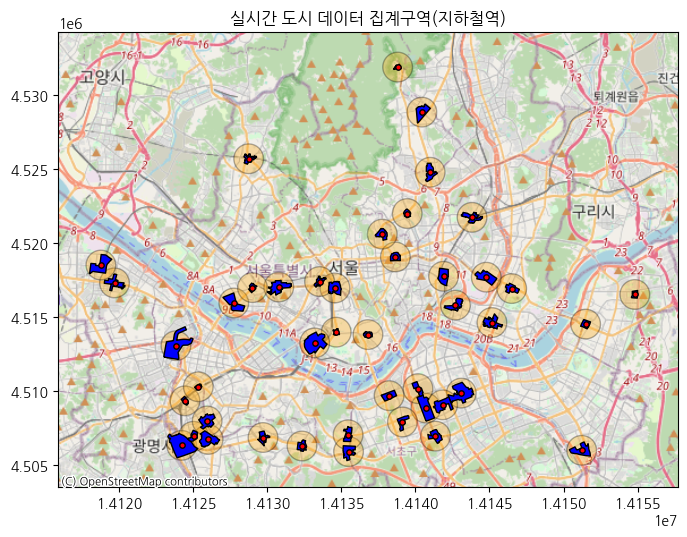

In [4]:
fig, ax1 = plt.subplots(figsize=(8, 6))
buffer_gdf.plot(ax=ax1, color='orange', edgecolor="black", alpha=0.3, legend=True)
ta_gdf.plot(ax=ax1, color='blue', edgecolor="black", legend=True)
ta_gdf.set_geometry('centroid').plot(ax=ax1, color='red', edgecolor="black", markersize=15)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("실시간 도시 데이터 집계구역(지하철역)")
plt.show()

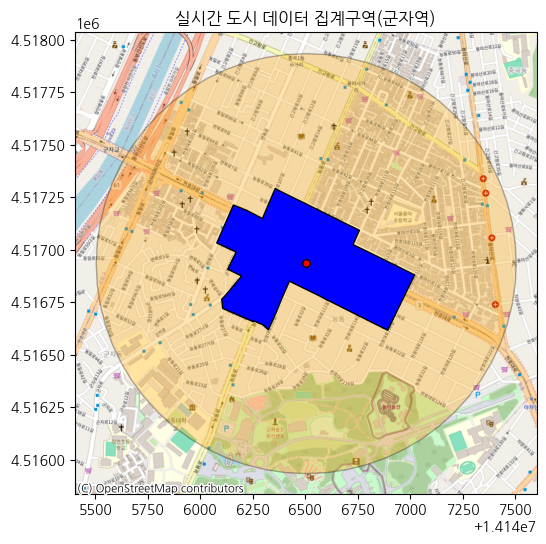

In [5]:
fig, ax1_1 = plt.subplots(figsize=(8, 6))
buffer_gdf.loc[ta_gdf['AREA_NM']=='군자역'].plot(ax=ax1_1, color='orange', edgecolor="black", alpha=0.3, legend=True)
ta_gdf.loc[ta_gdf['AREA_NM']=='군자역'].plot(ax=ax1_1, color='blue', edgecolor="black", legend=True)
ta_gdf.loc[ta_gdf['AREA_NM']=='군자역'].set_geometry('centroid').plot(ax=ax1_1, color='red', edgecolor="black", markersize=30)
ctx.add_basemap(ax1_1, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("실시간 도시 데이터 집계구역(군자역)")
plt.show()

### __상권 분포 시각화__

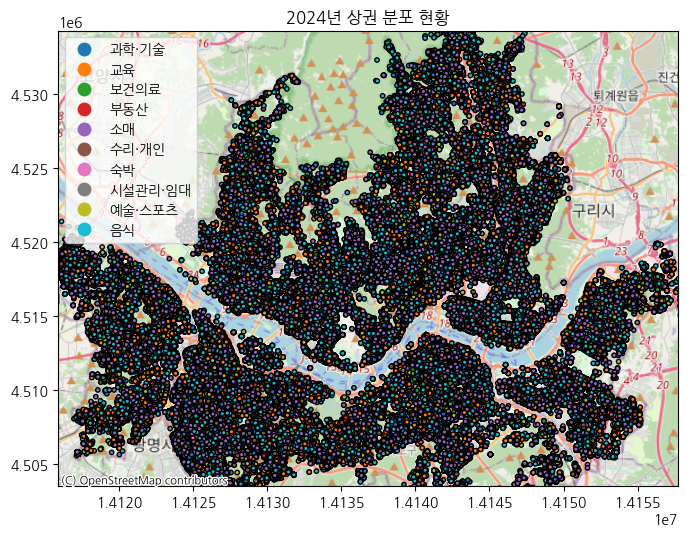

In [6]:
fig, ax2 = plt.subplots(figsize=(8, 6))
ag_gdf.plot(column='상권업종대분류명', ax=ax2, edgecolor="black", legend=True, markersize=10)
plt.xlim(ax1.get_xlim())
plt.ylim(ax1.get_ylim())
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("2024년 상권 분포 현황")
plt.show()

### __예시 지역(군자역) 반경 1km 내 상권 분포 현황__

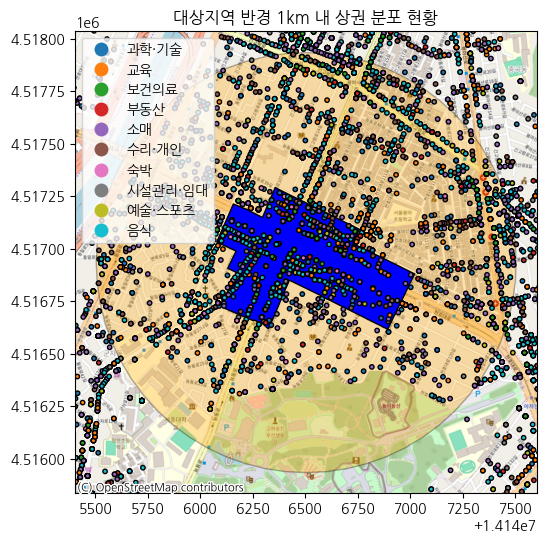

In [7]:
fig, ax3 = plt.subplots(figsize=(8, 6))
buffer_gdf.loc[ta_gdf['AREA_NM']=='군자역'].plot(ax=ax3, color='orange', edgecolor="black", alpha=0.3, legend=True)
ta_gdf.loc[ta_gdf['AREA_NM']=='군자역'].plot(ax=ax3, color='blue', edgecolor="black", legend=True)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
ag_gdf.plot(column='상권업종대분류명', ax=ax3, edgecolor="black", legend=True, markersize=10)
plt.xlim(xlim)
plt.ylim(ylim)
ctx.add_basemap(ax3, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("대상지역 반경 1km 내 상권 분포 현황")
plt.show()

In [10]:
# 공간 조인 수행
points_in_buffer = gpd.sjoin(ag_gdf, buffer_gdf, how='inner', predicate='within')

# 각 지하철역 반경 1km 내 위치하는 상호 수 계산
total_points = points_in_buffer.groupby('AREA_NM').size()

# 2. 각 지하철역 반경 1km 내 상권 별 포인트 개수 계산
category_counts = points_in_buffer.groupby(['AREA_NM', '상권업종대분류명']).size().unstack(fill_value=0)
category_counts['Total'] = total_points
display(category_counts.head())

# 지역 별 생활인구 평균 데이터와 결합
df_pop = pd.read_csv('./geospatial_util/생활인구 평균.csv', index_col=0)
df = df_pop.merge(category_counts, left_index=True, right_index=True, how='inner')
display(df.head())

상권업종대분류명,과학·기술,교육,보건의료,부동산,소매,수리·개인,숙박,시설관리·임대,예술·스포츠,음식,Total
AREA_NM,,,,,,,,,,,
가산디지털단지역,3554,249,72,333,1230,280,39,524,127,1078,7486
강남역,4258,1183,821,778,1598,689,99,597,319,2247,12589
건대입구역,568,229,132,184,964,456,95,132,239,1442,4441
고덕역,83,376,68,92,310,126,2,23,63,283,1426
고속터미널역,198,543,176,204,1760,194,6,50,85,524,3740


,총생활인구수,10gen_male,10gen_female,20gen_male,20gen_female,30gen_male,30gen_female,40gen_male,40gen_female,50gen_male,...,교육,보건의료,부동산,소매,수리·개인,숙박,시설관리·임대,예술·스포츠,음식,Total
가산디지털단지역,29500.580996,299.089328,281.959724,3083.482932,3365.741314,4760.407052,3144.055576,4413.243675,2122.025890,2885.326140,...,249,72,333,1230,280,39,524,127,1078,7486
강남역,59394.659445,1577.902805,1735.224544,5254.469020,7958.757592,5995.224117,5556.528189,4848.813996,3093.492274,2695.596774,...,1183,821,778,1598,689,99,597,319,2247,12589
건대입구역,21403.232926,671.697953,922.782401,3146.253669,4118.339796,1764.228114,1833.662767,1342.892689,1313.994611,1189.868878,...,229,132,184,964,456,95,132,239,1442,4441
고덕역,5303.349928,732.281117,441.027260,280.841729,302.853077,256.996169,284.531543,337.460173,470.933124,313.160976,...,376,68,92,310,126,2,23,63,283,1426
고속터미널역,8788.961230,228.024982,286.753408,670.145160,1107.864332,703.020317,1041.809046,636.716737,909.232405,512.258028,...,543,176,204,1760,194,6,50,85,524,3740


### __상관계수 분석 결과__
* 각 세대/연령별로 특정 상권과 높은 상관성을 나타내는 것을 발견
  * 예를들면, 학원 등 교육 상권이 집중된 지역은 타 지역에 비해 10대의 상관계수가 높게 나타남
  * 숙박의 경우, 전 세대에 걸쳐서 상관성이 낮은편이며, 타 세대에 비해 여행 등 숙박업소 이용률이 높은 20대에서만 0.2 이상을 나타내고 있음.
  * 부동산의 경우, 집 마련과 관련된 30대, 40대 세대에서 높은 상관성을 나타냄
* 본 분석 결과, 상권에 의해 지역 별로 유동인구 분포가 다를 수 있음을 확인할 수 있음
* 따라서, 인구 예측 모델 개발 시 지역 별로 각각의 모델을 구축 활용해야 한다고 판단함

<Axes: ylabel='상권업종대분류명'>

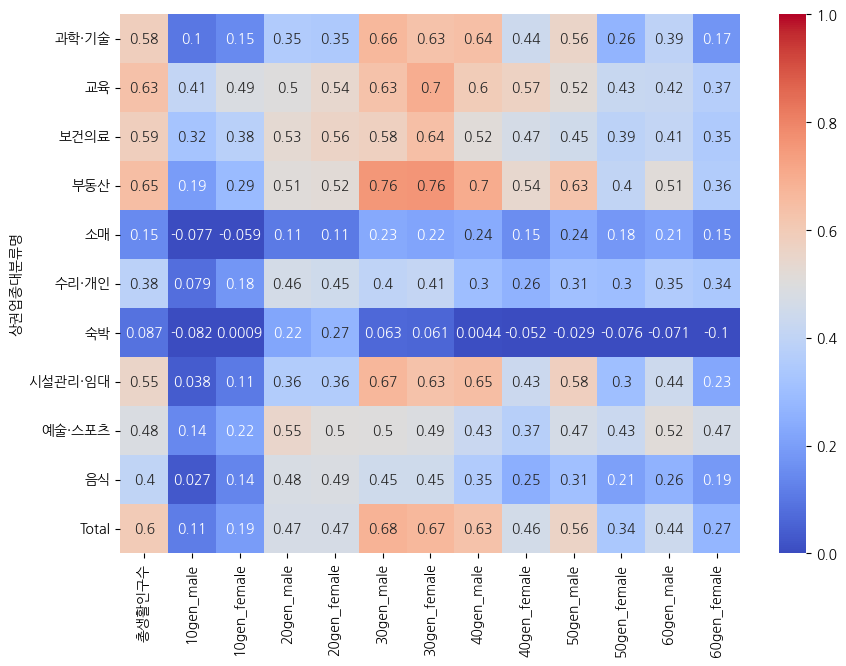

In [11]:
plt.figure(figsize=(10, 7))
df_corr = df.corr().loc[category_counts.columns, df_pop.columns]
sns.heatmap(df_corr, annot=True, cmap='coolwarm', vmin=0, vmax=1)